In [1]:
import gensim
import numpy as np
import pandas as pd
import os
import re
import csv
import codecs
import sys
import pickle

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from keras import callbacks
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import concatenate,Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
import pydot
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)


from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints


D:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [ ]:
!curl -L http://nlp.stanford.edu/data/glove.twitter.27B.zip --output glove.twitter.27B.zip


In [ ]:
!unzip glove.twitter.27B.zip


In [22]:
GloVe_DIR = 'glove.twitter.27B.50d.txt'
DATA_DIR = './data'

In [23]:
# hyperparameter
MAX_SENT_LEN_HEAD = 15 
MAX_SENT_LEN_BODY = 125
MAX_VOCAB_SIZE = 30000 
LSTM_DIM = 100 
EMBEDDING_DIM = 50 
BATCH_SIZE = 128
N_EPOCHS = 40

In [4]:
seed = 1
np.random.seed(seed)

In [5]:
train_bodies = pd.read_csv('./data/train_bodies.csv')
train_bodies.head(10)
test_bodies = pd.read_csv('./data/competition_test_bodies.csv')
test_bodies.head(10)

,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...
5,20,“I once sent Tim an email about the quality of...
6,21,Absolutely no one was devastated when news bro...
7,28,In designing its first wearable device in the ...
8,31,"The picture of a possible ""Crabzilla"" measurin..."
9,33,"Early Tuesday morning, Dornella Conner was “ri..."


In [6]:
# load training data
train_df = pd.read_csv(DATA_DIR + '/train_stances.csv')
# load testing data
test_df = pd.read_csv(DATA_DIR + '/competition_test_stances.csv')

In [7]:
# numeralize the stance label
train_df.replace('unrelated',1,True)
train_df.replace('agree',2,True)
train_df.replace('disagree',3,True)
train_df.replace('discuss',4,True)

test_df.replace('unrelated',1,True)
test_df.replace('agree',2,True)
test_df.replace('disagree',3,True)
test_df.replace('discuss',4,True)

In [8]:
# combine the bodyArticle with the main content
combine_df_train = train_df.join(train_bodies.set_index('Body ID'), on='Body ID')
combine_df_test = test_df.join(test_bodies.set_index('Body ID'), on='Body ID')

In [9]:
# text to wordsequence
word_seq_head_train = [text_to_word_sequence(head) for head in combine_df_train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(body) for body in combine_df_train['articleBody']]

word_seq_head_test = [text_to_word_sequence(head) for head in combine_df_test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(body) for body in combine_df_test['articleBody']]

In [10]:
word_seq = []
for i in range(len(word_seq_head_train)):
    word_seq.append(word_seq_head_train[i])
for i in range(len(word_seq_bodies_train)):
    word_seq.append(word_seq_bodies_train[i])

In [11]:
# use tokenizer API to map each token to unique integer
filter_list = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters=filter_list)
tokenizer.fit_on_texts([seq for seq in word_seq])
#because it only includes unique words(tokens)

print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 27873


In [12]:
# Convert the sequence of words to sequnce of indices
X_train_HEAD = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN_HEAD]) for seq in word_seq_head_train])
# list of list; join is to extend the list
X_train_HEAD = pad_sequences(X_train_HEAD, maxlen=MAX_SENT_LEN_HEAD, padding='post', truncating='post')
# y has already to be convert to 1,0 sequence
X_train_BODY = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN_BODY]) for seq in word_seq_bodies_train])
print(X_train_HEAD[1])
X_train_BODY = pad_sequences(X_train_BODY, maxlen=MAX_SENT_LEN_BODY, padding='post', truncating='post')
print(X_train_BODY[1])
y_train = combine_df_train['Stance']
y_train

[1060    4 9286 2530 7618    5 2535   18  991 7506 4770    0    0    0
    0]
[ 1060     4  9286    36  7081    22    51  1644   466   480    34   559
   485  1244     3   291     4  4770   159     1   136  7669     1  2535
  2141     5     1  6153     4     3   323  3999  3147  4198     1  2535
   617     4  2297    12     5     3   187     7  1210   979   836     6
  4045    22     1   617     4   220  1713    32  7081    52   102  3152
  2018    22   275  2421     4     1  2535  2141 10796  2535    34    51
  1644  5287    18   689  2927   744    52   102   133  3895  2535    20
  3658  7669     5   323   211  1563     3   701  4198     7   576  7811
  2825     6 21996  5007  4935   193     1  4198  6600   822     6   840
 21997    11  5240     4   692   157   161     4     1  4438  8652   145
  9286   189   636    19   991]


0        1
1        2
2        1
3        1
4        3
5        2
6        1
7        1
8        2
9        1
10       4
11       2
12       1
13       1
14       4
15       1
16       4
17       2
18       1
19       4
20       1
21       4
22       1
23       1
24       2
25       2
26       1
27       1
28       1
29       4
        ..
49942    1
49943    1
49944    4
49945    1
49946    4
49947    1
49948    1
49949    4
49950    1
49951    1
49952    1
49953    1
49954    1
49955    1
49956    4
49957    1
49958    1
49959    1
49960    1
49961    1
49962    1
49963    1
49964    1
49965    1
49966    1
49967    1
49968    1
49969    2
49970    4
49971    1
Name: Stance, Length: 49972, dtype: int64

In [13]:
# Convert the sequence of words to sequnce of indices
X_test_HEAD = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN_HEAD]) for seq in word_seq_head_test])
# list of list; join is to extend the list
X_test_HEAD = pad_sequences(X_test_HEAD, maxlen=MAX_SENT_LEN_HEAD, padding='post', truncating='post')
# y has already to be convert to 1,0 sequence
X_test_BODY = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN_BODY]) for seq in word_seq_bodies_test])
X_test_BODY = pad_sequences(X_test_BODY, maxlen=MAX_SENT_LEN_BODY, padding='post', truncating='post')
y_test = combine_df_test['Stance']
print(X_test_HEAD[1])
print(X_test_BODY[1])
y_test

[ 3083 10262    26   549     3 17239  5936   118   202   113     0     0
     0     0     0]
[ 8615 27680    80   300 13788   234  4644     8   165     5    46  2839
    80  5238  4644    46  2839     8   516     2  2719   300   849  4644
    18    15 10172     2  6578    63   300   100  1883    95  1032    24
  2713   215    10    46    80 16292   917     1  2614    50    23    52
   102    24     1  1676    54     3   234  9329     3   234    11    63
  6599  1197   102    63  1114  4644    80  5174    38   610  4406     1
  5238     6  5742    23 12461    81    46    80  8493  1707   932    78
     2     1   348    15  1062   543   137   439     1   657  3909    38
    23    29  4644    80   828   278   582   610  1062  1543     3  8887
     7 15332   277  2839    80  1180  1790  2614     4 14913    44  5539
    52   102  2316   278   582]


0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       2
11       1
12       4
13       1
14       4
15       2
16       1
17       1
18       1
19       1
20       4
21       2
22       2
23       3
24       4
25       1
26       1
27       4
28       1
29       2
        ..
25383    2
25384    3
25385    4
25386    2
25387    2
25388    3
25389    3
25390    2
25391    4
25392    3
25393    3
25394    2
25395    2
25396    3
25397    4
25398    2
25399    2
25400    3
25401    2
25402    3
25403    4
25404    2
25405    2
25406    3
25407    3
25408    2
25409    4
25410    3
25411    3
25412    2
Name: Stance, Length: 25413, dtype: int64

In [14]:
#encode train class values as integers(4 dimensions)
encoder_train = LabelEncoder()
encoder_train.fit(y_train)
encoded_train = encoder_train.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_train)

In [15]:
# spilt the dataset
X_train_HEAD, X_valid_HEAD, X_train_BODY, X_valid_BODY, y_train, y_valid = train_test_split(X_train_HEAD,X_train_BODY, dummy_y_train, random_state=10, test_size=0.1)

In [16]:
#encode test class values as integers
encoder_test = LabelEncoder()
encoder_test.fit(y_test)
encoded_test = encoder_test.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_test = np_utils.to_categorical(encoded_test)

#  build the model

In [ ]:
#GloVes Load
glove_input_file = GloVe_DIR
word2vec_output_file = 'glove.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

D:\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [29]:
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None     
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector

del embeddings
#delete

In [30]:
headline_embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embeddings_matrix],
                            input_length=MAX_SENT_LEN_HEAD,
                            trainable=True,mask_zero=True)

In [31]:
headline_sequence_input = Input(shape=(MAX_SENT_LEN_HEAD,))
embedded_headline = headline_embedding_layer(headline_sequence_input)
headline_lstm = LSTM(100, recurrent_dropout = 0.8, return_sequences = True, return_state = True)
encoder_outputs, state_h, state_c = headline_lstm(embedded_headline)

encoder_states = [state_h, state_c]

In [32]:
article_embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embeddings_matrix],
                            input_length=MAX_SENT_LEN_BODY,
                            trainable=True,mask_zero=True)

In [33]:
article_sequence_input = Input(shape=(MAX_SENT_LEN_BODY,))
embedded_article = article_embedding_layer(article_sequence_input)
article_lstm = LSTM(100, return_sequences = True)
encoded_article = article_lstm(embedded_article,initial_state=encoder_states)
encoded_article = Dropout(.8)(encoded_article)

In [34]:
class Attention(Layer):
    def __init__(self, attention_length = 15 ,
                 W_regularizer=None, 
                 W_constraint=None, 
                  **kwargs):

        #self.supports_masking = True
        #Xavier uniform initializer
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)

        self.W_constraint = constraints.get(W_constraint)

        self.attention_length = 15
        self.features_dim = 100 
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):        
        
        self.Wy = self.add_weight((self.features_dim,self.features_dim),
                                 initializer=self.init,
                                 name='{}_Wy'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        

        
        self.Wh = self.add_weight((self.features_dim,self.features_dim),
                                     initializer=self.init,
                                     name='{}_Wh'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)

        self.w = self.add_weight((self.features_dim,1),
                                     initializer=self.init,
                                     name='{}_x'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)

        self.Wp = self.add_weight((self.features_dim,self.features_dim),
                                     initializer=self.init,
                                     name='{}_Wp'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)
        
        self.Wx = self.add_weight((self.features_dim,self.features_dim),
                                     initializer=self.init,
                                     name='{}_Wx'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        
        #x is a list containing the output hidden layers of first LSTM(), and the final state of seconde LSTM(body)
        Y_states = tf.slice(x[0], begin = [0, 0, 0], size = [-1, self.attention_length, -1]) #outputs of headline states
        h_state = x[1][:,-1,:] #output state of article lstm
        print ("Y_states", Y_states.shape)
        print ("h_state",h_state.shape)
        
        features_dim = self.features_dim
       

        M1 = K.reshape(K.dot(K.reshape(Y_states, (-1, features_dim)), self.Wy),shape = (-1,self.attention_length,features_dim ))
        M2 = K.expand_dims(K.dot(h_state, self.Wh),axis=1)
        M = K.tanh(M1+M2)
        alpha = K.reshape(K.softmax(K.dot(K.reshape(M, shape = (-1, features_dim)), self.w)), shape = (-1, self.attention_length))
        r = tf.squeeze(tf.matmul(tf.transpose(tf.expand_dims(alpha, 2), perm = [0, 2, 1]), Y_states))
        h_star = tf.tanh(tf.matmul(r, self.Wp) + tf.matmul(h_state, self.Wx))
        

        return h_star

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim

In [35]:
AttentionLayer = Attention()
attention_res = AttentionLayer([encoder_outputs, encoded_article] )

preds = Dense(4, activation='softmax')(attention_res)

Y_states (?, 15, 100)
h_state (?, 100)


In [36]:
model = Model(inputs=[ headline_sequence_input,article_sequence_input], outputs=preds)
optimizer = optimizers.Adam(lr=0.001)  

model.compile(optimizer = optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy' ])

filepath="./checkpoint/LSTM with conditional encoding and attention_{epoch:02d}_{val_acc:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_acc', 
                                       verbose=0, 
                                       save_best_only=True)

callbacks_list = [checkpoint]

history = model.fit([X_train_HEAD, X_train_BODY], y_train, validation_data = ([ X_valid_HEAD,X_valid_BODY], y_valid), batch_size=BATCH_SIZE, epochs=N_EPOCHS,callbacks = callbacks_list)

Train on 44974 samples, validate on 4998 samples
Epoch 1/40
44974/44974 [==============================] - 136s 3ms/step - loss: 0.7833 - acc: 0.7285 - val_loss: 0.7069 - val_acc: 0.7439


D:\Anaconda3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_4:0' shape=(?, 100) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/40
44974/44974 [==============================] - 136s 3ms/step - loss: 0.6492 - acc: 0.7534 - val_loss: 0.5789 - val_acc: 0.7721
Epoch 3/40
44974/44974 [==============================] - 140s 3ms/step - loss: 0.5381 - acc: 0.7831 - val_loss: 0.4867 - val_acc: 0.8015
Epoch 4/40
44974/44974 [==============================] - 145s 3ms/step - loss: 0.4563 - acc: 0.8163 - val_loss: 0.4336 - val_acc: 0.8213
Epoch 5/40
44974/44974 [==============================] - 146s 3ms/step - loss: 0.3918 - acc: 0.8421 - val_loss: 0.3801 - val_acc: 0.8449
Epoch 6/40
44974/44974 [==============================] - 145s 3ms/step - loss: 0.3514 - acc: 0.8580 - val_loss: 0.3482 - val_acc: 0.8619
Epoch 7/40
44974/44974 [==============================] - 155s 3ms/step - loss: 0.3224 - acc: 0.8699 - val_loss: 0.3341 - val_acc: 0.8655
Epoch 8/40
44974/44974 [==============================] - 169s 4ms/step - loss: 0.2946 - acc: 0.8824 - val_loss: 0.3106 - val_acc: 0.8796
Epoch 9/40
44974/44974 [==========

In [37]:
with open('./history/history(LSTM_with conditional encoding and attention_training)', 'wb') as f:
        pickle.dump(history.history, f)

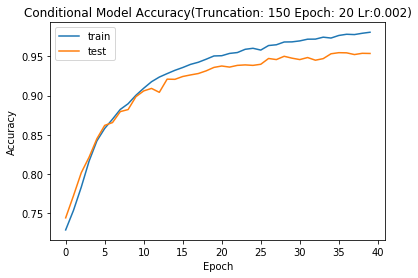

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Conditional Model Accuracy(Truncation: 150 Epoch: 20 Lr:0.002)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

In [39]:
score, acc = model.evaluate([X_test_HEAD,X_test_BODY], y_test, batch_size=BATCH_SIZE)
acc

25413/25413 [==============================] - 27s 1ms/step


0.6857513870868159

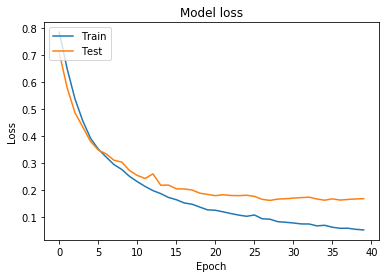

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction

In [89]:
# Load the best trained model with highest accuracy
from keras import models
model_file_path = './checkpoint/LSTM with conditional encoding and attention_36_0.9548.h5'
model = models.load_model(model_file_path,custom_objects = {'Attention': Attention()})

Y_states (?, 15, 100)
h_state (?, 100)


In [90]:
prediction = model.predict([X_test_HEAD,X_test_BODY])

In [91]:
preds = [np.argmax(p, axis = -1) for p in prediction]

In [92]:
actuals = [np.argmax(p, axis = -1) for p in y_test]

In [93]:
for i in range(len(preds)):
    if preds[i] == 0: preds[i] = "unrelated"
    if preds[i] == 1: preds[i] = "disagree"
    if preds[i] == 2: preds[i] = "agree"
    if preds[i] == 3: preds[i] = "discuss"

for i in range(len(actuals)):
    if actuals[i] == 0: actuals[i] = "unrelated"
    if actuals[i] == 1: actuals[i] = "disagree"
    if actuals[i] == 2: actuals[i] = "agree"
    if actuals[i] == 3: actuals[i] = "discuss"


In [94]:
type(preds)

list

In [95]:
stance_list = preds
bodyid_list = []
headline_list = []

In [96]:
test_df_original = pd.read_csv(DATA_DIR + '/competition_test_stances.csv')
test_df_original.head(10)

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated
5,Next-generation Apple iPhones' features leaked,2353,unrelated
6,Saudi national airline may introduce gender se...,192,unrelated
7,'Zombie Cat' Claws Way Out Of Grave And Into O...,2482,unrelated
8,"ISIS might be harvesting organs, Iraq tells UN",250,unrelated
9,Woman has surgery to get third breast: The thr...,85,unrelated


In [97]:
# save the csv file for submission
for i in range(len(test_df_original.Stance)):
    bodyid_list.append(test_df_original['Body ID'][i])
    headline_list.append(test_df_original.Headline[i])
   
df = pd.DataFrame(data={'Headline': headline_list, 'Body ID': bodyid_list, "Stance": stance_list})
df.to_csv("bidirectional_LSTM_attention_conditional_encoding_submission.csv")